In [96]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import yfinance as yf
pd.options.mode.chained_assignment = None

In [97]:
#Defininfo o período de referência para treinamento do modelo
acao = "MGLU3.SA"
inicio = "2014-12-31"
fim = "2022-09-15"
dados_acao = yf.download(acao, inicio, fim)

[*********************100%%**********************]  1 of 1 completed


In [98]:
#Pegando os dados da cotação no ato do fechamento, não na cotação ajustada
cotacao = dados_acao['Close'].to_numpy().reshape(-1, 1)

In [99]:
#Definindo para serem treinados apenas 80% dos dados evitando o sobreajuste (overfitting)
dados_sendo_treinados = int(len(cotacao) * 0.8)
type(dados_sendo_treinados)

int

In [100]:
#Escalonando os dados para uma escala entre 0 e 1 facilitando o treinamento da rede
escalador_dados = MinMaxScaler(feature_range=(0, 1))
dados_0_1_treinamento = escalador_dados.fit_transform(cotacao[0: dados_sendo_treinados, :])
dados_0_1_testes = escalador_dados.transform(cotacao[dados_sendo_treinados: , :])
dados_0_1 = list(dados_0_1_treinamento.reshape(len(dados_0_1_treinamento))) + list(dados_0_1_testes.reshape(len(dados_0_1_testes)))
dados_0_1 = np.array(dados_0_1).reshape(len(dados_0_1), 1)


In [101]:
dados_a_treinar = dados_0_1[0: dados_sendo_treinados, :]

#Dados que irão gerar o resultado (cotações dos 60 dias passados)
treinamento_x = []
#Cotação real 
treinamento_y = []


for i in range(60, len(dados_a_treinar)):
    treinamento_x.append(dados_a_treinar[i -60: i, 0])
    treinamento_y.append(dados_a_treinar[i, 0])

In [102]:
#Adequando o array para 3 dimensões para seguir o modelo de treinamento
treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)

treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)



In [103]:
modelo = Sequential()

#O modelo será construído com 50 neurônios

modelo.add(LSTM(50, return_sequences=True, input_shape = (treinamento_x.shape[1], 1)))
modelo.add(LSTM(50, return_sequences=False))
modelo.add(Dense(25))
modelo.add(Dense(1))

treinamento_x.shape[1]

C:\Users\isacv\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60

In [104]:
#O modelo irá utilizar o algorítimo Adam como otimizador e terá sua função de erro medida em erro quadrático
modelo.compile(optimizer="adam", loss="mean_squared_error")

In [105]:
#O modelo será otimizado a cada 1 iteração e neste momento só itera 1 vez sobre todo os dados
modelo.fit(treinamento_x, treinamento_y, batch_size=1, epochs=1)

1472/1472 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 0.0060


In [106]:
#Criando os dados para teste do modelo
dados_teste = dados_0_1[dados_sendo_treinados - 60:, :]

teste_x = []

teste_y = cotacao[dados_sendo_treinados: , :]

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])

In [107]:
#Reshape dos dados de teste

teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

In [108]:
#Instanciando as predições do modelo
predicoes = modelo.predict(teste_x)

#Removendo as escalas
predicoes = escalador_dados.inverse_transform(predicoes)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [109]:
#Erro médio quadrático (RMSE)
erro_medio = np.sqrt(np.mean(predicoes - teste_y) ** 2)

In [112]:
#Representação em gráfico

treinamento = dados_acao.iloc[:dados_sendo_treinados, :]
df_Base = pd.DataFrame({"Close": dados_acao['Close'].iloc[dados_sendo_treinados:], "predicoes": predicoes.reshape(len(predicoes))})

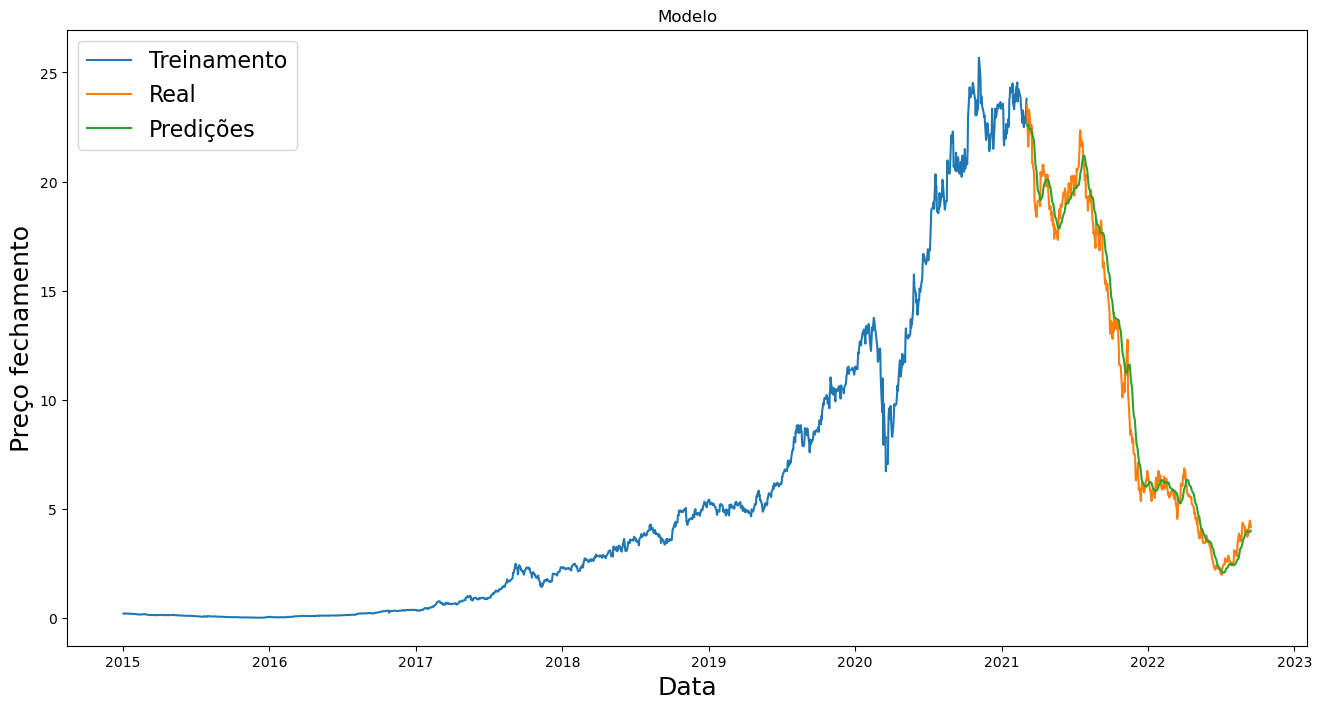

In [113]:
plt.figure(figsize=(16,8))
plt.title("Modelo")
plt.xlabel('Data', fontsize = 18)
plt.ylabel("Preço fechamento", fontsize = 18)
plt.plot(treinamento['Close'])
plt.plot(df_Base[['Close', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Predições'], loc = 2, prop = {'size': 16})
plt.show()